In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision import datasets, transforms
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import shutil
import copy
import sys

import PIL
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans, MiniBatchKMeans
from statistics import mean
from collections  import OrderedDict
import numpy as np
from skimage import io, transform
import random
import scipy
import cv2
from math import floor, ceil

# !pip install torchinfo
from torchinfo import summary

%matplotlib inline

In [2]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval()
for name, param in alexnet.named_parameters():
    print(name, param)

features.0.weight Parameter containing:
tensor([[[[ 1.1864e-01,  9.4069e-02,  9.5435e-02,  ...,  5.5822e-02,
            2.1575e-02,  4.9963e-02],
          [ 7.4882e-02,  3.8940e-02,  5.2979e-02,  ...,  2.5709e-02,
           -1.1299e-02,  4.1590e-03],
          [ 7.5425e-02,  3.8779e-02,  5.4930e-02,  ...,  4.3596e-02,
            1.0225e-02,  1.3251e-02],
          ...,
          [ 9.3155e-02,  1.0374e-01,  6.7547e-02,  ..., -2.0277e-01,
           -1.2839e-01, -1.1220e-01],
          [ 4.3544e-02,  6.4916e-02,  3.6164e-02,  ..., -2.0248e-01,
           -1.1376e-01, -1.0719e-01],
          [ 4.7369e-02,  6.2543e-02,  2.4758e-02,  ..., -1.1844e-01,
           -9.5567e-02, -8.3890e-02]],

         [[-7.2634e-02, -5.7996e-02, -8.0661e-02,  ..., -6.0304e-04,
           -2.5309e-02,  2.5471e-02],
          [-6.9042e-02, -6.7562e-02, -7.6367e-02,  ..., -3.9616e-03,
           -3.0402e-02,  1.0477e-02],
          [-9.9517e-02, -8.5592e-02, -1.0521e-01,  ..., -2.6587e-02,
           -2.2777

In [3]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
img_width = 224
img_height = 224
channels = 3
summary(alexnet, (1,channels, img_width, img_height))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  --                        --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [5]:
params = list(alexnet.named_parameters())
print(len(params))

16


In [6]:
params[0]

('features.0.weight',
 Parameter containing:
 tensor([[[[ 1.1864e-01,  9.4069e-02,  9.5435e-02,  ...,  5.5822e-02,
             2.1575e-02,  4.9963e-02],
           [ 7.4882e-02,  3.8940e-02,  5.2979e-02,  ...,  2.5709e-02,
            -1.1299e-02,  4.1590e-03],
           [ 7.5425e-02,  3.8779e-02,  5.4930e-02,  ...,  4.3596e-02,
             1.0225e-02,  1.3251e-02],
           ...,
           [ 9.3155e-02,  1.0374e-01,  6.7547e-02,  ..., -2.0277e-01,
            -1.2839e-01, -1.1220e-01],
           [ 4.3544e-02,  6.4916e-02,  3.6164e-02,  ..., -2.0248e-01,
            -1.1376e-01, -1.0719e-01],
           [ 4.7369e-02,  6.2543e-02,  2.4758e-02,  ..., -1.1844e-01,
            -9.5567e-02, -8.3890e-02]],
 
          [[-7.2634e-02, -5.7996e-02, -8.0661e-02,  ..., -6.0304e-04,
            -2.5309e-02,  2.5471e-02],
           [-6.9042e-02, -6.7562e-02, -7.6367e-02,  ..., -3.9616e-03,
            -3.0402e-02,  1.0477e-02],
           [-9.9517e-02, -8.5592e-02, -1.0521e-01,  ..., -2.6587

In [7]:
print((params[0][0]))
print(len(params[0][1]))
print(type(params[0][1]))

features.0.weight
64
<class 'torch.nn.parameter.Parameter'>


In [ ]:
layer2_mult_count

In [8]:
for param_tensor in alexnet.state_dict():
    #print(type(alexnet.state_dict()[param_tensor]))
    print(param_tensor, "\t", alexnet.state_dict()[param_tensor].size())

features.0.weight 	 torch.Size([64, 3, 11, 11])
features.0.bias 	 torch.Size([64])
features.3.weight 	 torch.Size([192, 64, 5, 5])
features.3.bias 	 torch.Size([192])
features.6.weight 	 torch.Size([384, 192, 3, 3])
features.6.bias 	 torch.Size([384])
features.8.weight 	 torch.Size([256, 384, 3, 3])
features.8.bias 	 torch.Size([256])
features.10.weight 	 torch.Size([256, 256, 3, 3])
features.10.bias 	 torch.Size([256])
classifier.1.weight 	 torch.Size([4096, 9216])
classifier.1.bias 	 torch.Size([4096])
classifier.4.weight 	 torch.Size([4096, 4096])
classifier.4.bias 	 torch.Size([4096])
classifier.6.weight 	 torch.Size([1000, 4096])
classifier.6.bias 	 torch.Size([1000])


In [9]:
conv1_weights = alexnet.state_dict()['features.0.weight']
conv1_bias = alexnet.state_dict()['features.0.bias']

In [10]:
conv1_weights[0]

tensor([[[ 1.1864e-01,  9.4069e-02,  9.5435e-02,  1.0515e-01,  1.0291e-01,
           6.7224e-02,  5.0466e-02,  5.0125e-02,  5.5822e-02,  2.1575e-02,
           4.9963e-02],
         [ 7.4882e-02,  3.8940e-02,  5.2979e-02,  7.5955e-02,  7.2286e-02,
           7.2904e-02,  5.2016e-02,  2.7115e-02,  2.5709e-02, -1.1299e-02,
           4.1590e-03],
         [ 7.5425e-02,  3.8779e-02,  5.4930e-02,  5.5807e-02,  5.2543e-02,
           5.0020e-02,  4.7630e-02,  2.5285e-02,  4.3596e-02,  1.0225e-02,
           1.3251e-02],
         [ 7.0420e-02,  5.2510e-02,  6.3095e-02,  6.2153e-02,  5.8876e-02,
           3.8574e-02,  4.5036e-02,  3.8129e-02,  4.5773e-02,  1.9212e-03,
           2.9633e-03],
         [ 8.7315e-02,  7.4974e-02,  7.1627e-02,  8.3448e-02,  9.4555e-02,
           6.5405e-02,  3.3532e-02,  2.1039e-02,  2.2060e-02, -1.0646e-02,
          -3.4279e-02],
         [ 9.5834e-02,  9.9245e-02,  1.0057e-01,  1.0878e-01,  7.2587e-02,
           3.6077e-02, -7.4826e-03, -4.3091e-02, -3.788

In [11]:
filter_count = conv1_weights.shape[0]
depth = conv1_weights.shape[1]
height = conv1_weights.shape[2]
width = conv1_weights.shape[3]

print(filter_count, depth, height, width)

64 3 11 11


In [12]:
conv1_bias[0]

tensor(-0.9705)

In [13]:
print(type(conv1_weights[0][0][0][0]))
print(type(conv1_bias))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [91]:
stride = 4
padding = 2
channels_out = filter_count
width_out = floor((img_width+2*padding-width)/stride+1)
height_out = floor((img_height+2*padding-height)/stride+1)
print(width_out, height_out)

55 55


In [92]:
def process_image(img_path):
    img = PIL.Image.open(img_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img)
    test_transform = transforms.Compose([transforms.ToPILImage(),
                                         transforms.CenterCrop(224), 
                                         transforms.Pad(padding), 
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                        ])
    img = test_transform(img_tensor)
    #print(img.shape)
    return img

In [93]:
def compute_kmeans(kernel, num_cluster):    
    centroids = []
    labels = []
    flattened_weights = kernel.reshape(-1)
    flattened_weights = flattened_weights.reshape(height*width*depth,1)
    kmeans = MiniBatchKMeans(n_clusters=num_cluster, batch_size=height*width, compute_labels=True)
    kmeans.fit(flattened_weights)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
#     print(labels)
#     print(len(labels))
#     print(type(labels))
#     print(labels.shape)
    return centroids, labels

In [109]:
kernel_centroids = []
kernel_means = []

for it in range(channels_out):
    centroids, labels = compute_kmeans(conv1_weights[it], depth*width)
    kernel_centroids.append(centroids)
    kernel_means.append(labels)

C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\User

C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\User

C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\User

In [100]:
def compute_conv(img, num_clusters, centroids, labels, weights, r, c):
    img_out_cell = 0
    conv_mult_count = 0
    act_clusters = torch.zeros(1,num_clusters)
    for i in range(width*depth*height):
        act_clusters[0][labels[i]] += img[floor(i/(height*width))][r+floor((i%(width*height))/width)][c+floor(i%width)]
    for it in range(width):
        img_out_cell += act_clusters[0][it]*centroids[it]
        conv_mult_count += 1
    return img_out_cell, conv_mult_count

In [101]:
def compute_filter_conv(img, num_clusters, centroids, labels, weights, bias, kernel_id):
    img_out_channel = torch.zeros(width_out,height_out)
    filter_mult_count = 0
    for r in range(0,img_height+2*padding-height,stride):
        for c in range(0,img_width+2*padding-width,stride):
            r_out = floor(r/stride)
            c_out = floor(c/stride)
            #print(r_out, c_out)
            img_out_channel[r_out][c_out], mult_count = compute_conv(img, num_clusters, centroids, labels, weights, r, c)
            img_out_channel[r_out][c_out] += bias
            filter_mult_count += mult_count
    return img_out_channel, filter_mult_count

In [116]:
def compute_conv_layer(img_path, weights, bias):
    img = process_image(img_path)
    layer_mult_count = 0
    img_conv_output = torch.zeros(channels_out, width_out, height_out)
    for kernel_id in range(filter_count):
        if kernel_id%8==0:
            print("kernel_id", kernel_id)
        weights = conv1_weights[kernel_id]
        centroids, labels = compute_kmeans(weights, depth*width)
        num_clusters = width*depth
        img_conv_channel, mult_count = compute_filter_conv(img, num_clusters, centroids, labels, weights, conv1_bias[kernel_id], kernel_id)
        img_conv_output[kernel_id] = img_conv_channel
        layer_mult_count += mult_count
    return img_conv_output, layer_mult_count

In [103]:
img_path = r"C:\Users\ameyv\BTP\val\ILSVRC2010_val_00000132.JPEG"
layer1_output, layer_mult_count = compute_conv_layer(img_path, conv1_weights, conv1_bias)

kernel_id 0


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 1


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 2


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 3


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 4


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 5


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 6


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 7


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 8


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 9


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 10


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 11


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 12


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 13


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 14


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 15


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 16


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 17


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 18


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 19


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 20


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 21


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 22


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 23


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 24


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 25


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 26


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 27


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 28


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 29


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 30


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 31


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 32


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 33


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 34


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 35


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 36


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 37


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 38


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 39


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 40


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 41


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 42


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 43


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 44


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 45


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 46


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 47


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 48


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 49


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 50


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 51


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 52


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 53


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 54


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 55


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 56


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 57


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 58


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 59


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 60


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 61


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 62


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


kernel_id 63


C:\Users\ameyv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [4]:
print(layer_mult_count)

21298600


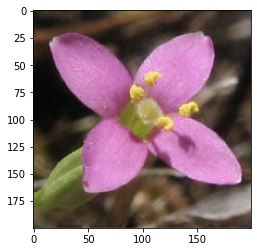

In [111]:
pil_img = PIL.Image.open(img_path)
plt.imshow(pil_img)

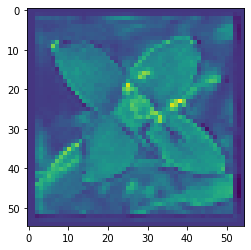

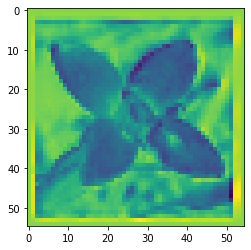

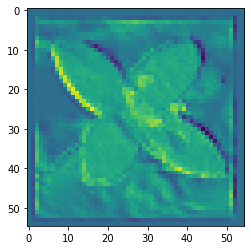

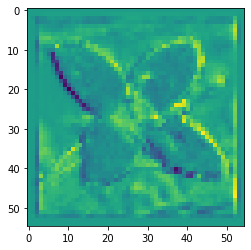

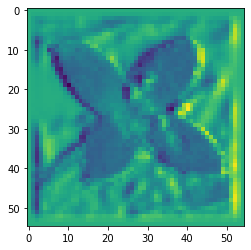

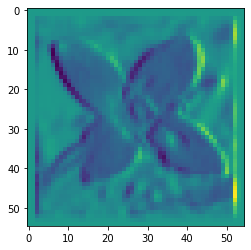

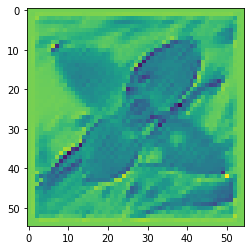

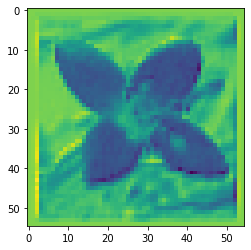

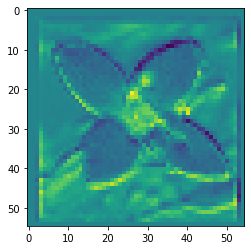

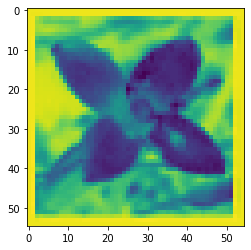

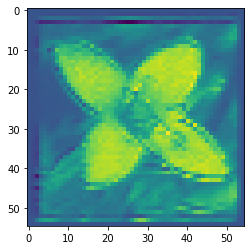

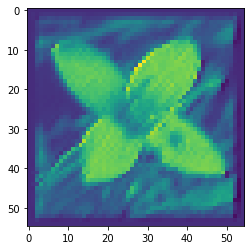

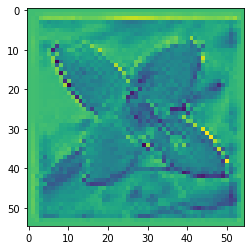

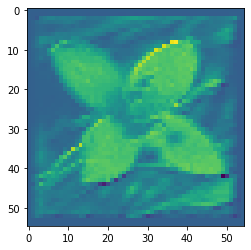

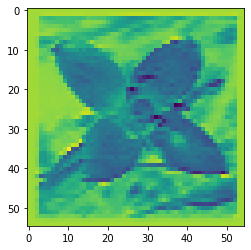

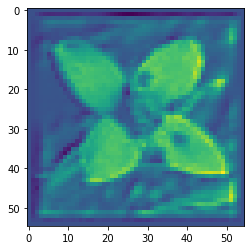

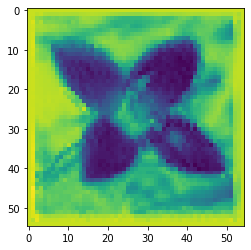

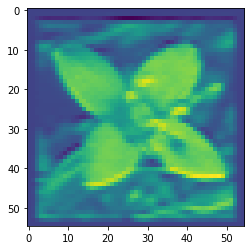

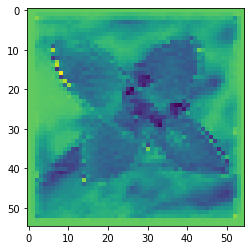

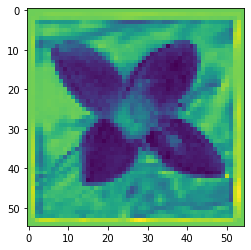

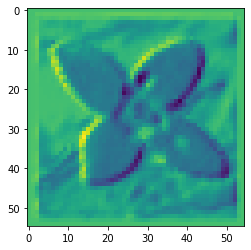

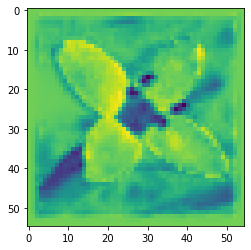

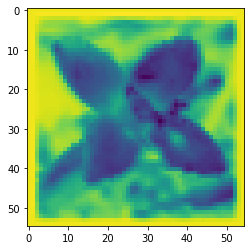

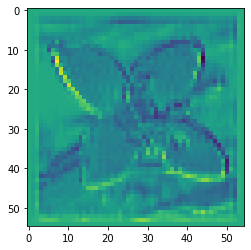

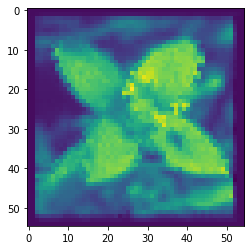

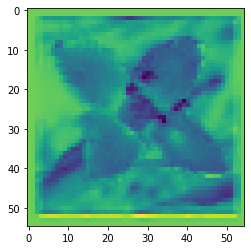

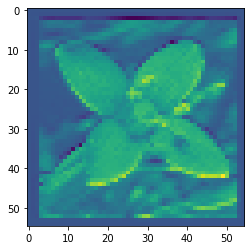

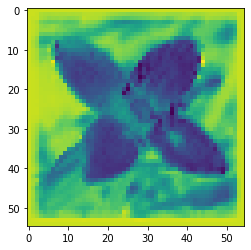

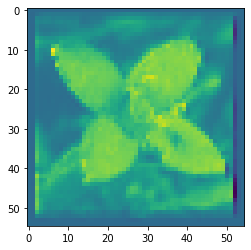

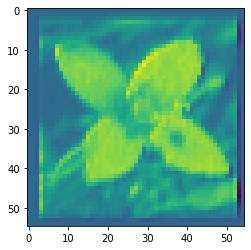

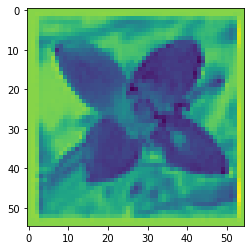

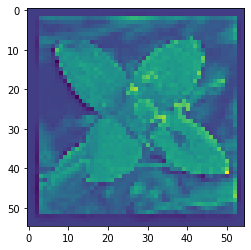

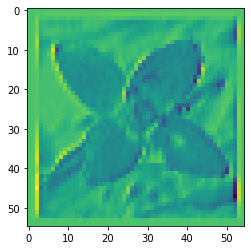

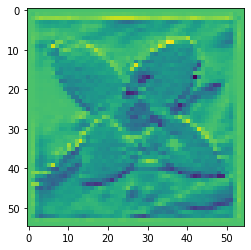

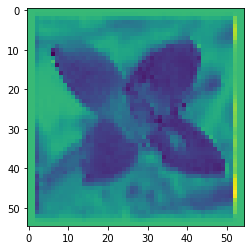

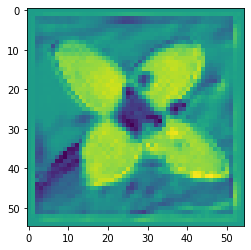

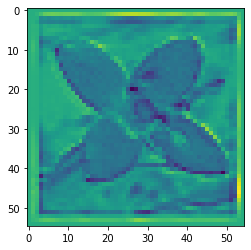

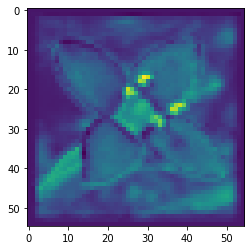

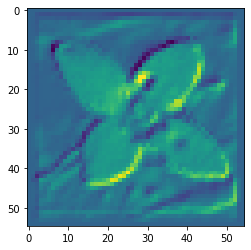

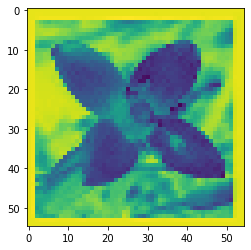

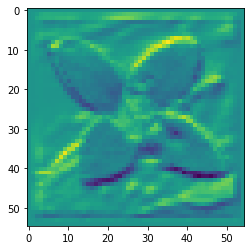

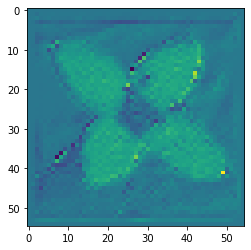

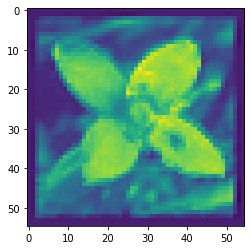

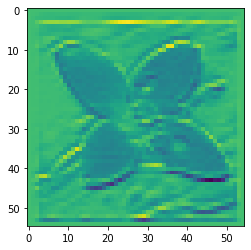

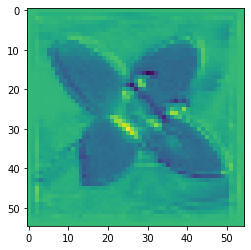

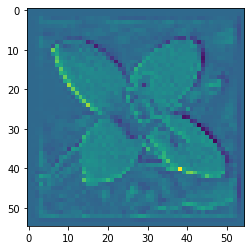

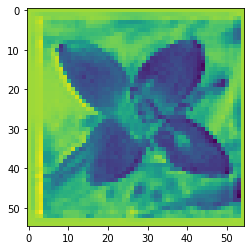

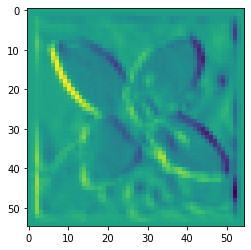

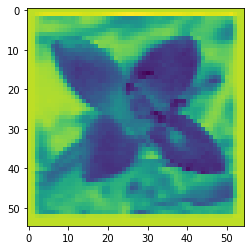

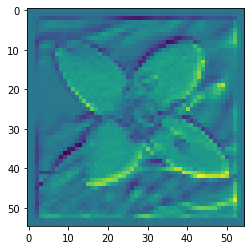

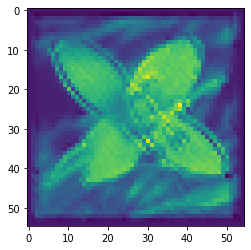

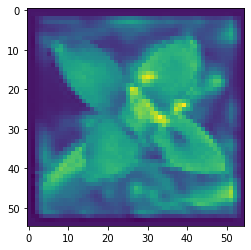

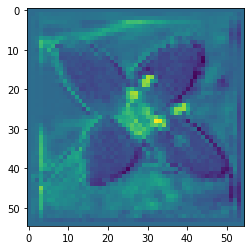

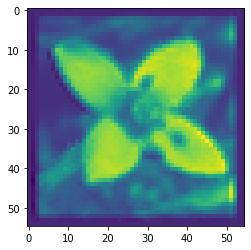

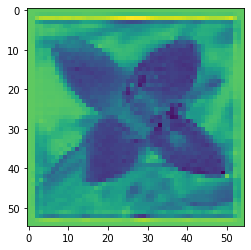

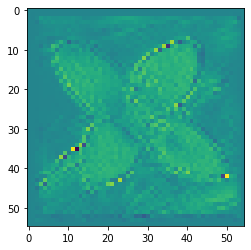

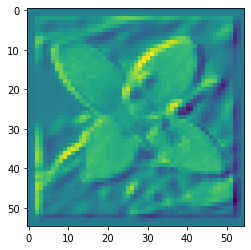

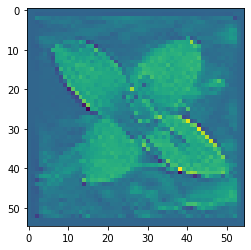

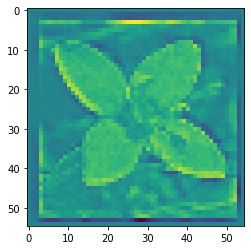

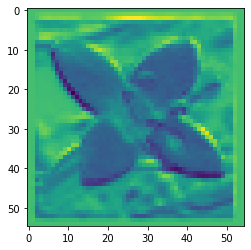

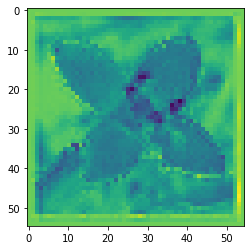

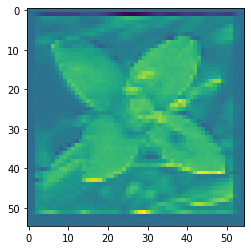

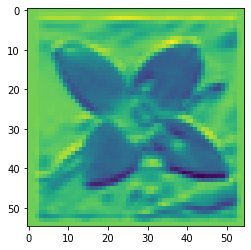

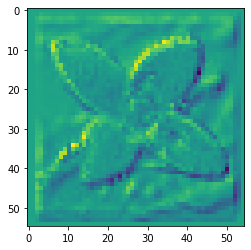

In [112]:
plt.figure()

for kernel in range(64):
    plt.imshow(layer1_output[kernel])
    plt.show()

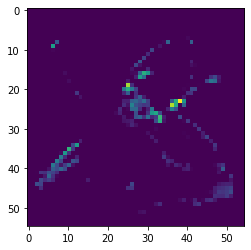

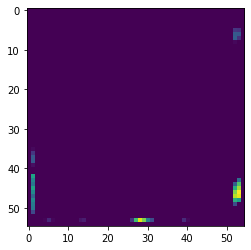

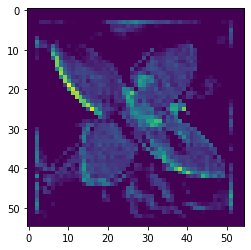

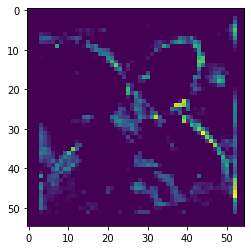

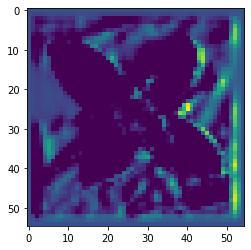

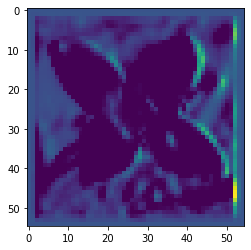

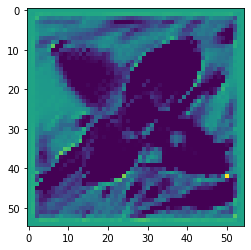

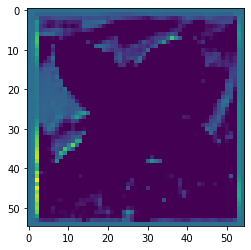

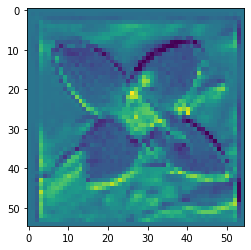

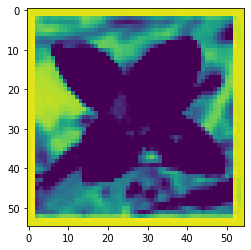

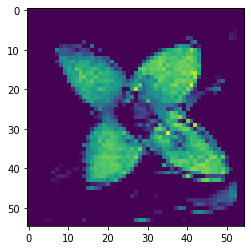

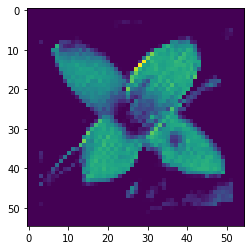

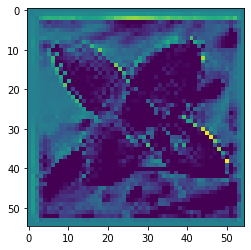

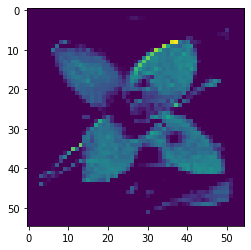

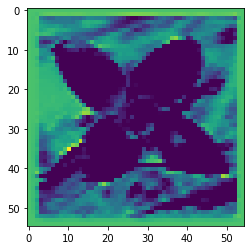

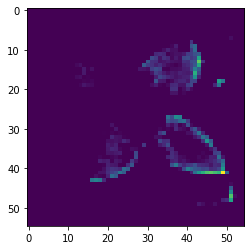

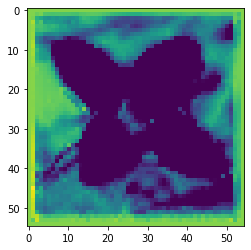

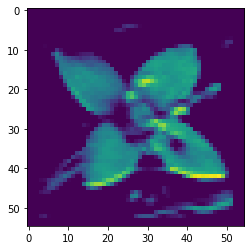

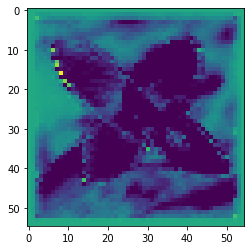

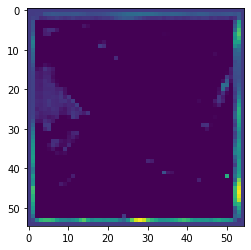

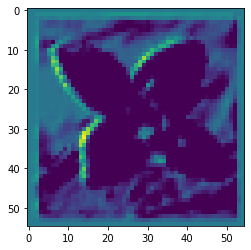

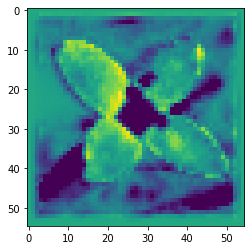

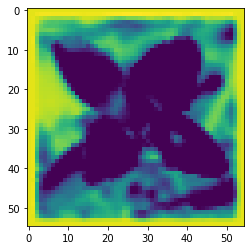

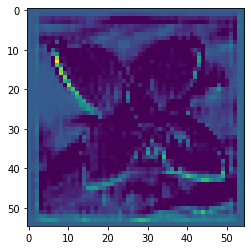

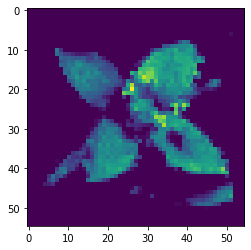

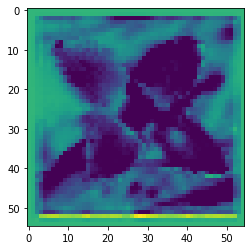

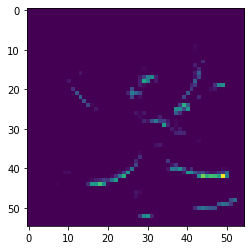

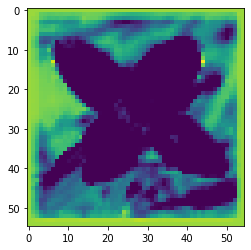

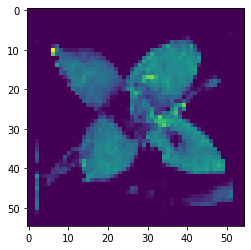

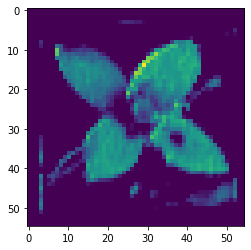

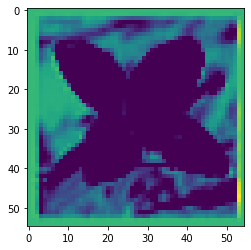

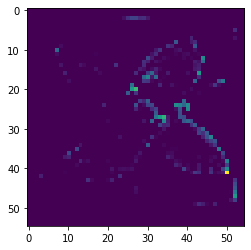

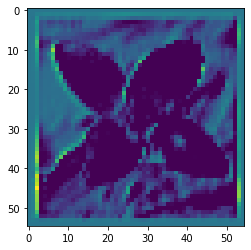

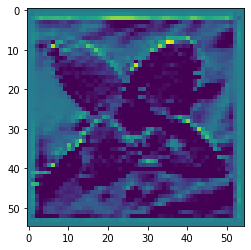

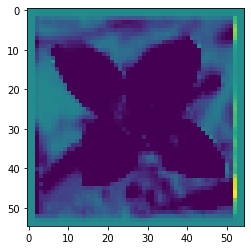

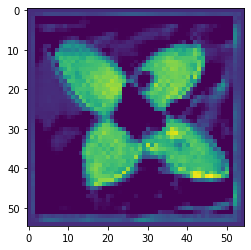

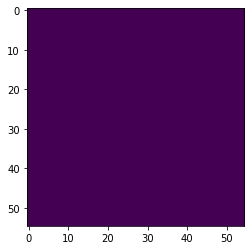

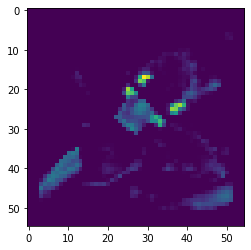

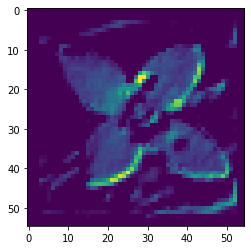

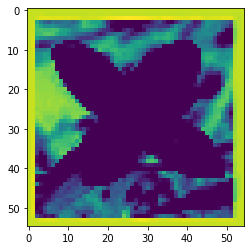

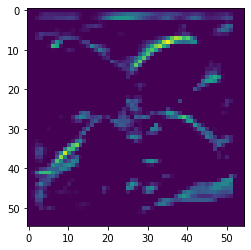

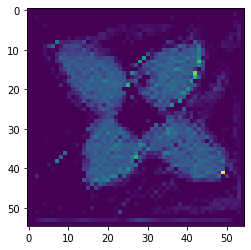

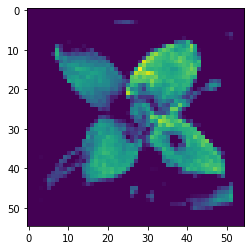

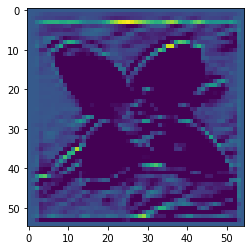

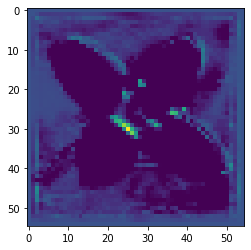

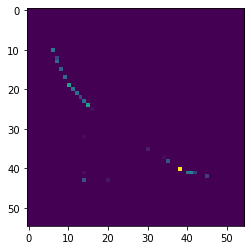

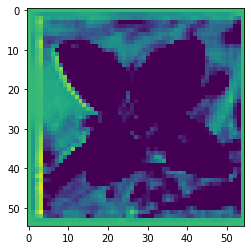

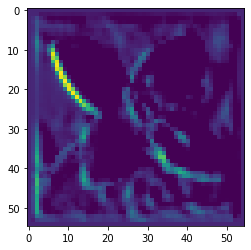

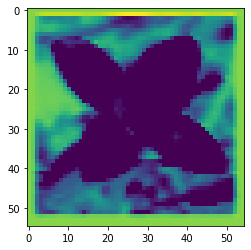

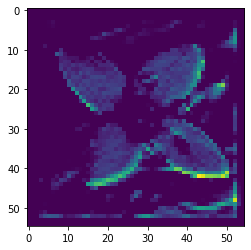

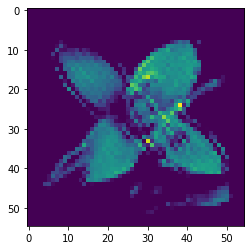

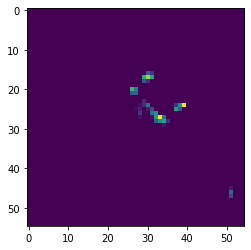

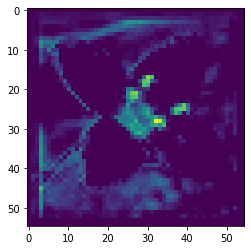

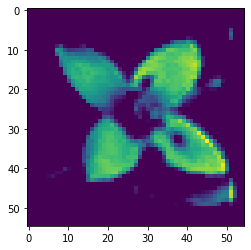

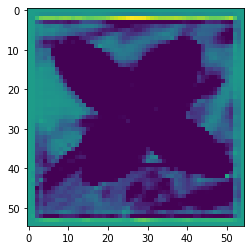

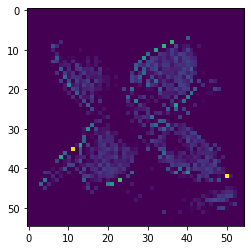

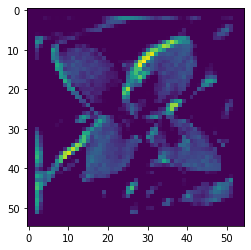

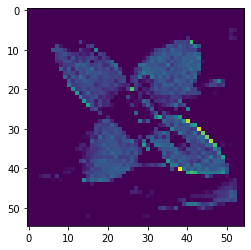

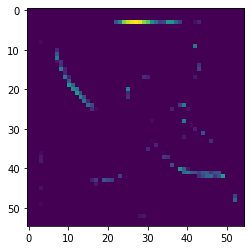

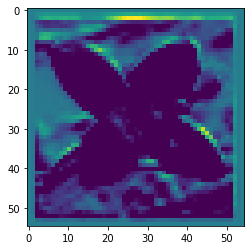

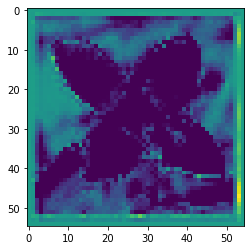

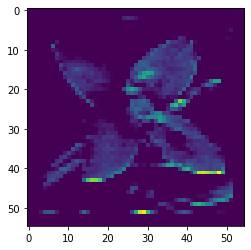

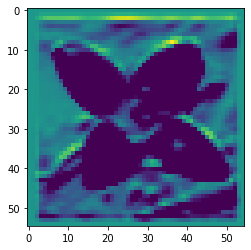

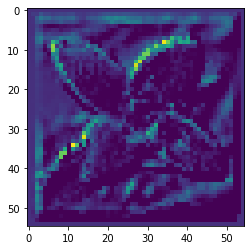

In [114]:
relu1_output = F.relu(layer1_output)

for kernel in range(64):
    plt.imshow(relu1_output[kernel])
    plt.show()

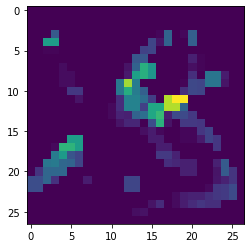

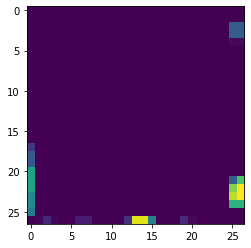

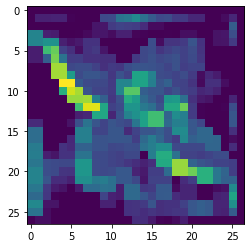

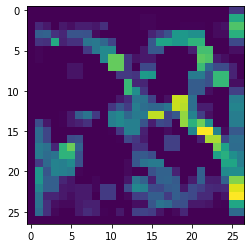

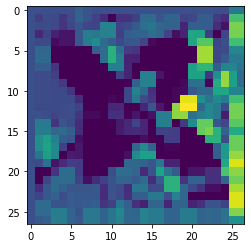

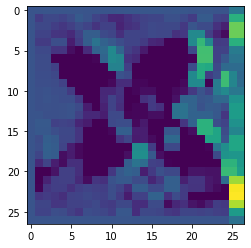

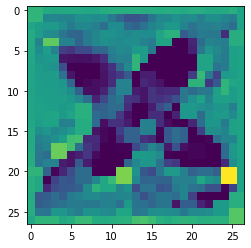

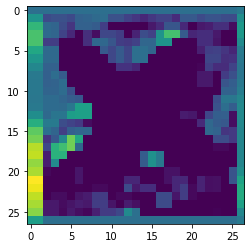

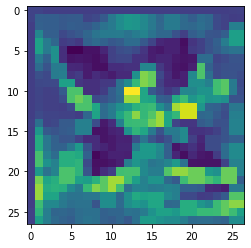

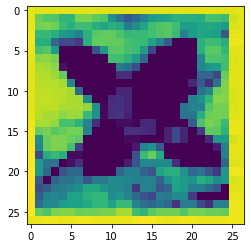

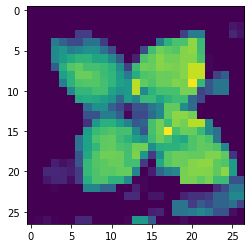

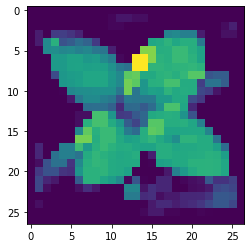

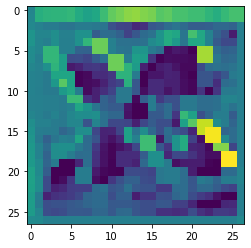

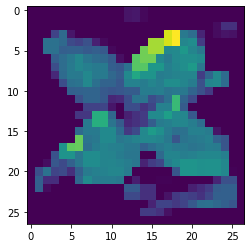

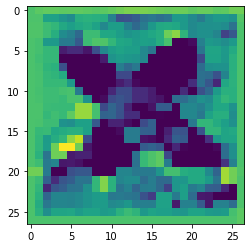

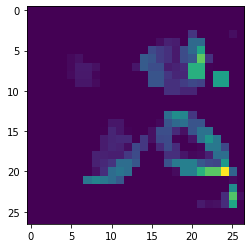

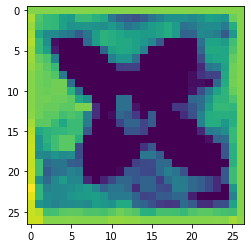

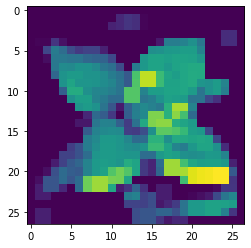

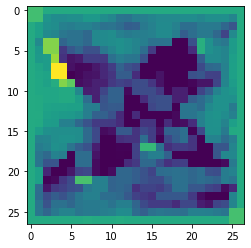

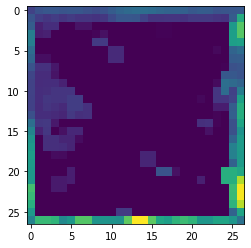

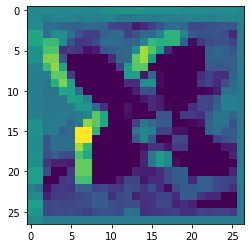

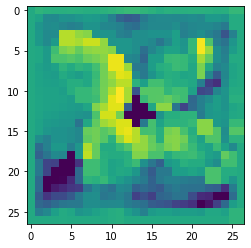

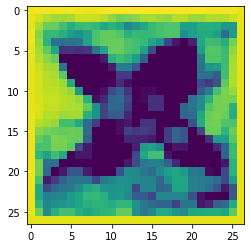

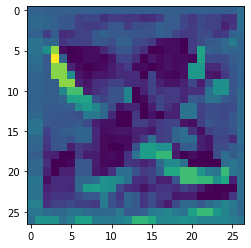

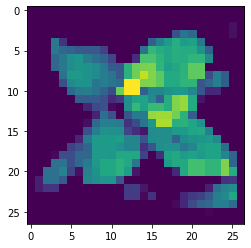

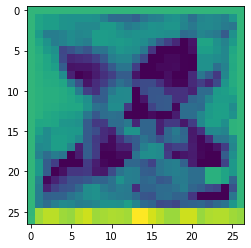

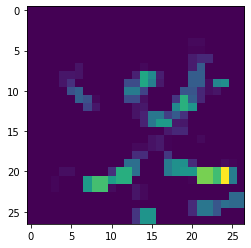

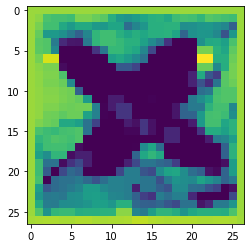

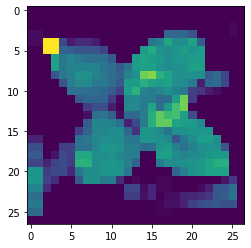

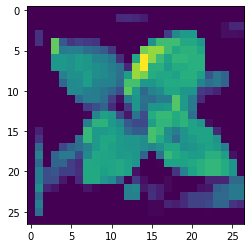

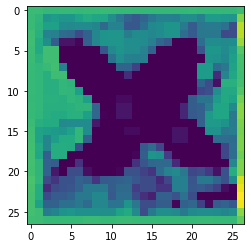

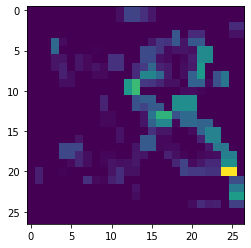

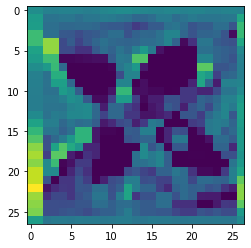

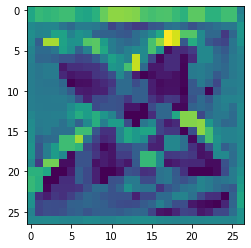

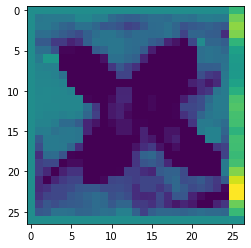

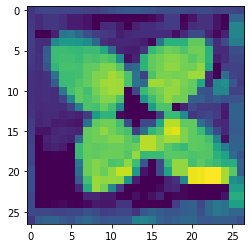

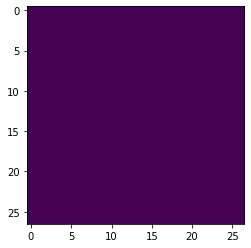

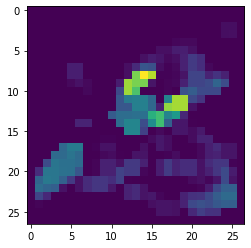

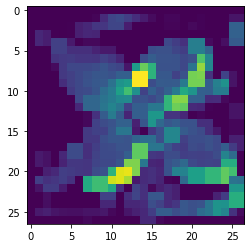

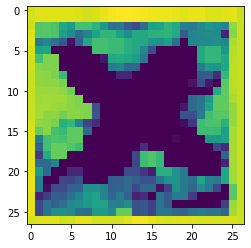

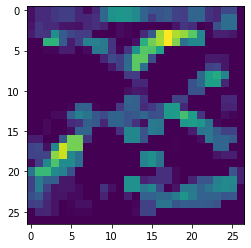

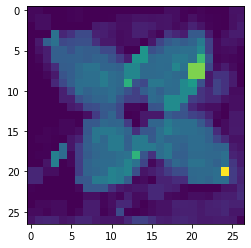

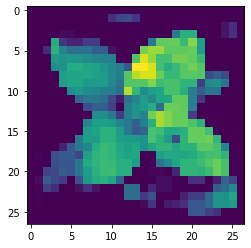

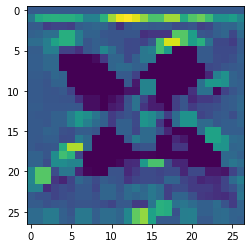

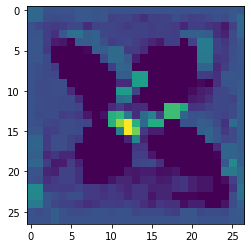

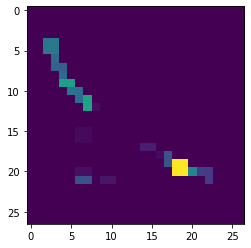

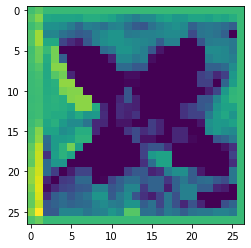

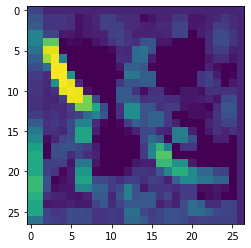

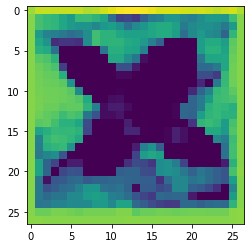

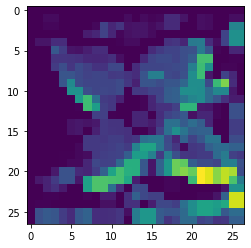

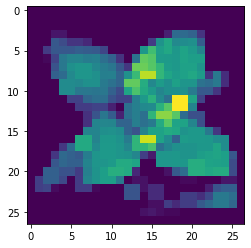

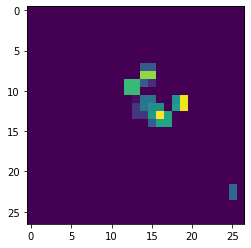

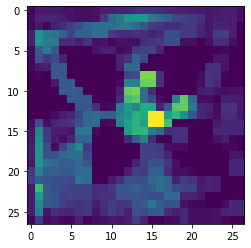

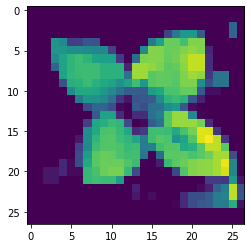

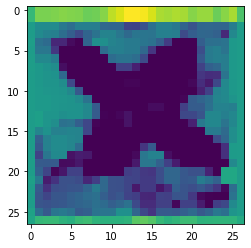

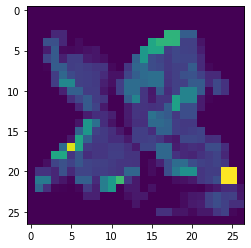

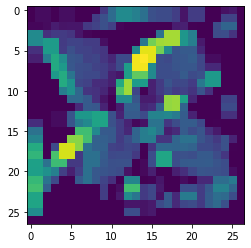

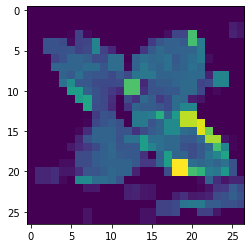

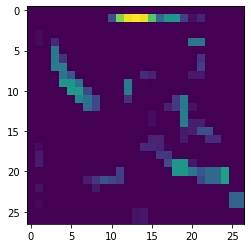

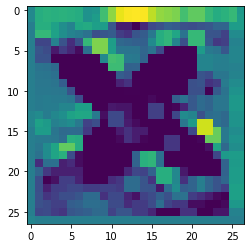

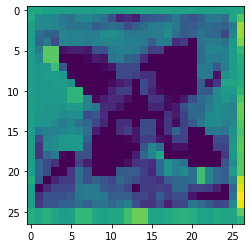

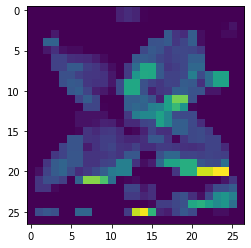

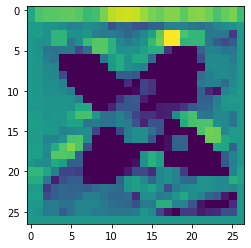

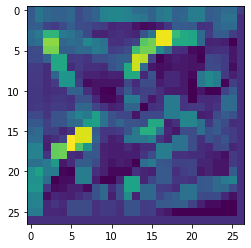

In [115]:
pool1_output = F.max_pool2d(relu1_output, 3, stride=2, padding=0, dilation=1)

for kernel in range(64):
    plt.imshow(pool1_output[kernel])
    plt.show()

In [ ]:
conv2_weights = alexnet.state_dict()['features.3.weight']
conv2_bias = alexnet.state_dict()['features.3.bias']

In [ ]:
### Implementing Testing for 10 image samples (Average Multiplication Counts) ###
img_count = 10
mult_counts = np.zeros(img_count)
for it in range(img_count):
    number_str = str(it+1)
    zero_filled_number = str(number_str.zfill(5))
    file_base = r"C:\Users\ameyv\BTP\val\ILSVRC2010_val_000"
    img_path =  file_base + zero_filled_number +'.JPEG'
    layer1_output, layer_mult_count = compute_conv_layer(img_path, conv1_weights, conv1_bias)
    print(it," ",layer_mult_count)
    mult_counts[it] = layer_mult_count

In [ ]:
stride = 1
padding = 2
channels_out = 192
img_width = 55
img_height = 55
width_out = floor((img_width+2*padding-width)/stride+1)
height_out = floor((img_height+2*padding-height)/stride+1)
print(width_out, height_out)

In [ ]:
filter_count = conv2_weights.shape[0]
depth = conv2_weights.shape[1]
height = conv2_weights.shape[2]
width = conv2_weights.shape[3]
print(filter_count, depth, height, width)

In [ ]:
layer2_output, layer2_mult_count = compute_conv_layer(img_path, conv2_weights, conv2_bias)
relu2_output = F.relu(layer2_output)
pool2_output = F.max_pool2d(relu2_output, 3, stride=2, padding=0, dilation=1)

In [ ]:
print(layer2_mult_count)